# Problem Set 2: Window based Stereo Matching
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. SSD Stereo (Simple Image)

In [3]:
# Load images
img1l = cv2.imread('Data/leftTest.png', 0)
img1l = img1l.astype(np.float32) / 255
img1r = cv2.imread('Data/rightTest.png', 0)
img1r = img1r.astype(np.float32) / 255

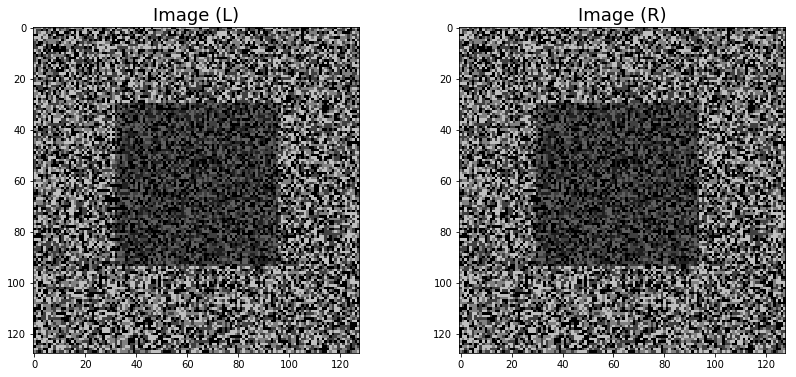

In [4]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L)')
ax[0].imshow(img1l, clim=(0,1))
ax[1].set_title('Image (R)')
ax[1].imshow(img1r, clim=(0,1));

In [5]:
def disparity_ssd(imgl, imgr, window_size=11, max_offset=100):
    '''
    Generate left and right disparity images from a stereo pair by 
    comparing the sum of square differences (SSD) of template windows.
    '''
    # Allow only odd window sizes
    assert(window_size%2 == 1)
    # Check dims
    assert(imgl.shape == imgr.shape)
    # Initializations
    k = window_size // 2
    h, w = imgl.shape
    # Summing kernel
    kernel = np.ones((window_size, window_size), np.float)
    # Accumulate SSDs for each offset
    ssdl = np.full((h, w, max_offset+1), np.inf, np.float)
    ssdr = np.full((h, w, max_offset+1), np.inf, np.float)
    for offset in range(max_offset+1):
        sd = (imgl[:, offset:] - imgr[:, :w-offset]) ** 2
        ssdl[k:-k, k+offset:-k, offset] = ssdr[k:-k, k:-k-offset, offset] = correlate2d(sd, kernel, mode='valid')
    # Disparity images
    factor = 1.0 / max_offset
    depthl = ssdl.argmin(-1) * factor
    depthr = ssdr.argmin(-1) * factor
    return depthl, depthr

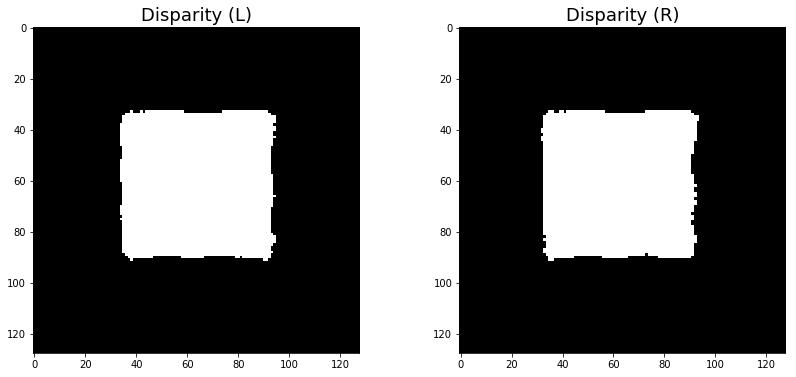

In [6]:
# Calculate diparity
Dl1, Dr1 = disparity_ssd(img1l, img1r, max_offset=2)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dl1, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Dr1, clim=(0,1));

---
## 2. SSD Stereo (First Image)

In [7]:
# Load images
img2l = cv2.imread('Data/proj2-pair1-L.png', 0)
img2l = img2l.astype(np.float32) / 255
img2r = cv2.imread('Data/proj2-pair1-R.png', 0)
img2r = img2r.astype(np.float32) / 255

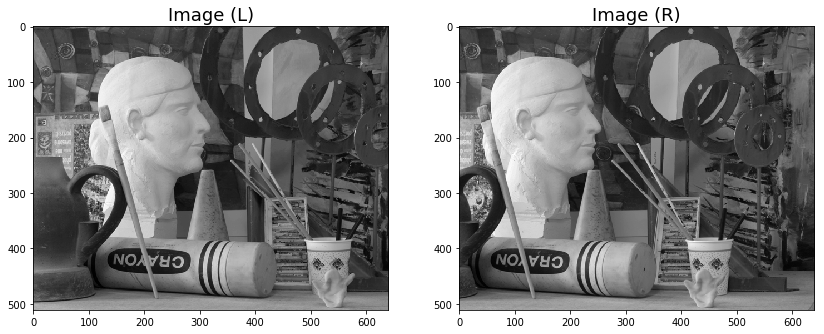

In [8]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L)')
ax[0].imshow(img2l)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

### a. Disparity Images

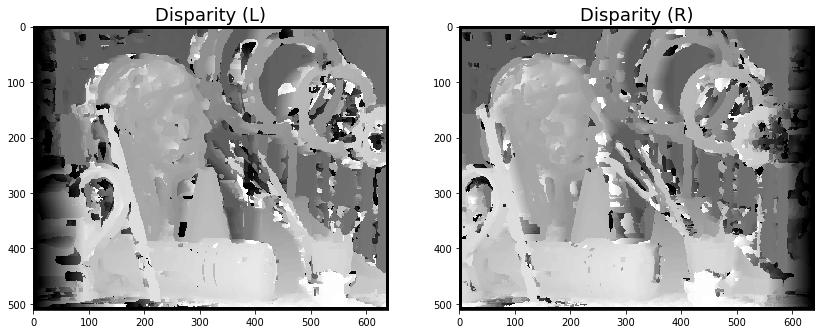

In [9]:
# Calculate Disparity
Dl2, Dr2 = disparity_ssd(img2l, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dl2, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Dr2, clim=(0,1));

### b. Comparison to Ground Truth

In [10]:
# Load ground truth
img2lgt = cv2.imread('Data/proj2-pair1-Disp-L.png', 0)
img2lgt = img2lgt.astype(np.float32) / 255
img2rgt = cv2.imread('Data/proj2-pair1-Disp-R.png', 0)
img2rgt = img2rgt.astype(np.float32) / 255

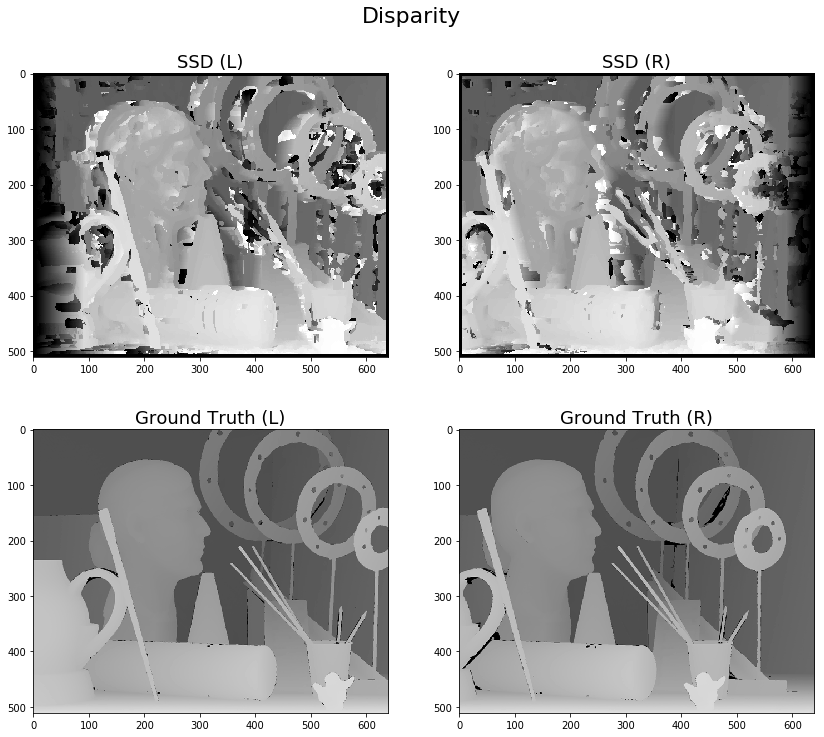

In [11]:
# Plot comparison
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('SSD (L)')
ax[0, 0].imshow(Dl2, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img2lgt, clim=(0,1));
ax[0, 1].set_title('SSD (R)')
ax[0, 1].imshow(Dr2, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img2rgt, clim=(0,1));

The disparity images generated are significantly worse compared to the ground truth. Some differences have been highlighted below:
- Since the points on the extreme left (or extreme right) don't correspond to any points on the other image, they result in essentially useless values.
- The ground truth images are extremely smooth while the SSD disparity images are not. This may be because of different intensity characteristics of the cameras.
- Occluded points result in noisy values. This is because these too don't have any correspondences in the other image and need to be separately handled to get smooth disparity values.

---
## 3. SSD Stereo: Effect of Perturbations (First Image)
### a. Noise
Noise is added only to the left image.

In [12]:
# Noise Params
sigma = 0.05
noise = np.random.normal(0, sigma, img2l.shape).astype(np.float32)
# Add noise
img2ln = img2l + noise
img2ln = img2ln.clip(0.0, 1.0)

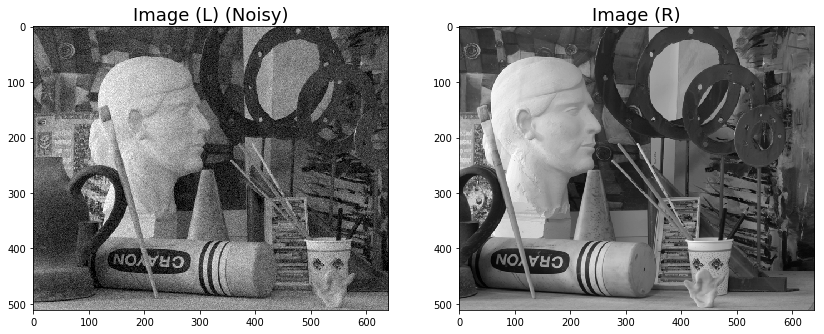

In [13]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L) (Noisy)')
ax[0].imshow(img2ln)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

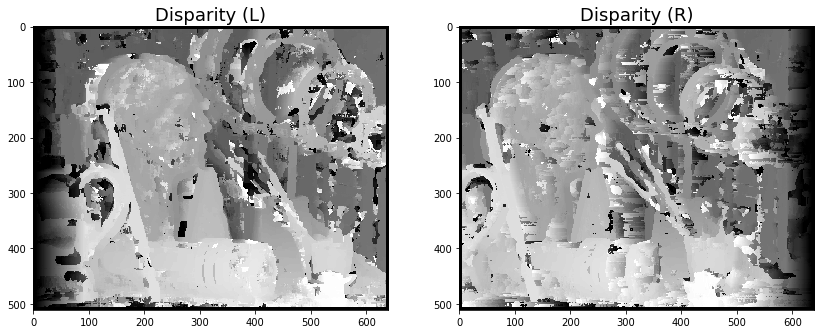

In [14]:
# Calculate diparity
Dln2, Drn2 = disparity_ssd(img2ln, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dln2, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drn2, clim=(0,1));

The left disparity image is surprisingly robust to the added noise, while the right one has a significant degradation. This can be explained by the fact that while checking for left to right correspondences, the SSD of each candidate window increases by approximately the same amount (noise added to the window pixels in the left image). Thus, the minimum of all the candidate windows remains almost the same. On the other hand, while checking for right to left correspondences, the SSD of each candidate window increases by different amounts based on the noise added to the particular pixels in the left image window. Hence, the minimum is usually different, and we don't get an accurate disparity measure.

### b. Different Contrasts

In [15]:
# Increase contrast of left image
img2lc = 1.1 * img2l
img2lc = img2lc.clip(0.0, 1.0)

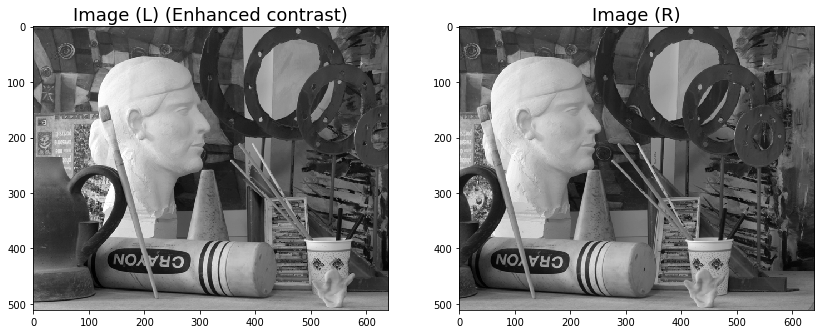

In [16]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (L) (Enhanced contrast)')
ax[0].imshow(img2lc)
ax[1].set_title('Image (R)')
ax[1].imshow(img2r);

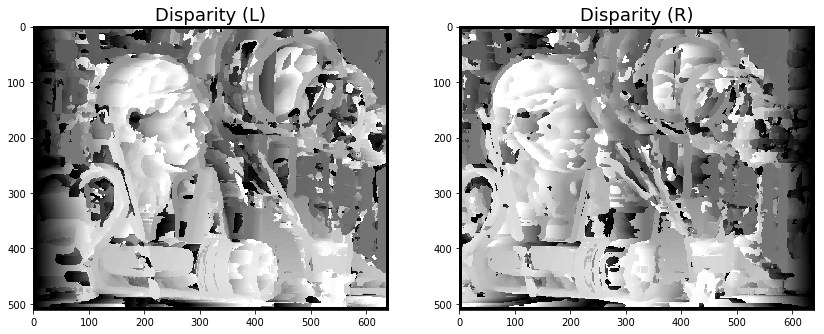

In [17]:
# Calculate diparity
Dlc2, Drc2 = disparity_ssd(img2lc, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dlc2, clim=(0,1))
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drc2, clim=(0,1));

Since there is no normalization while calculating SSD, a difference in contrast leads to inaccurate results.

---
## 4. Normalized Cross Correlation Stereo (First Image)
### a. Original Image

In [18]:
def disparity_ncorr(imgl, imgr, window_size=11, max_offset=100):
    '''
    Generate left and right disparity images from a stereo pair by 
    comparing the Normalized cross correlation of template windows.
    '''
    # Allow only odd window sizes
    assert(window_size % 2 == 1)
    # Check dims
    assert(imgl.shape == imgr.shape)
    # Initializations
    k = window_size // 2 
    h, w = imgl.shape
    # Accumulate Normalized correlations for each offset
    ssdl = np.zeros((h, w, max_offset+1), np.float)
    ssdr = np.zeros((h, w, max_offset+1), np.float)
    for y in range(k, h-k):
        for x in range(k, w-k):
            if x-k-max_offset < 0:
                ssdl[y, x, :x-k-max_offset] = np.fliplr(cv2.matchTemplate(imgr[y-k:y+k+1, :x+k+1], imgl[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED))
            else:
                ssdl[y, x, :] = np.fliplr(cv2.matchTemplate(imgr[y-k:y+k+1, x-k-max_offset:x+k+1], imgl[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED))
            if x+k+max_offset+1 > w:
                 ssdr[y, x, :w-(x+k+1+max_offset)] = cv2.matchTemplate(imgl[y-k:y+k+1, x-k:], imgr[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED)
            else:
                ssdr[y, x, :] = cv2.matchTemplate(imgl[y-k:y+k+1, x-k:x+k+1+max_offset], imgr[y-k:y+k+1, x-k:x+k+1], cv2.TM_CCORR_NORMED)
    # Disparity images
    factor = 1.0 / max_offset
    depthl = ssdl.argmax(-1) * factor
    depthr = ssdr.argmax(-1) * factor
    return depthl, depthr

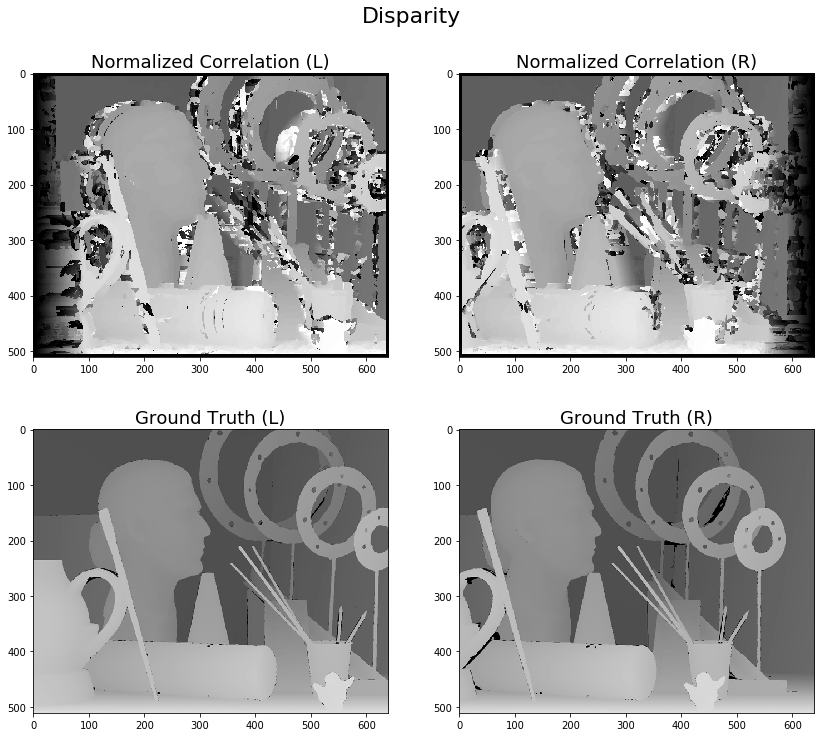

In [19]:
# Calculate diparity
Dl2ncorr, Dr2ncorr = disparity_ncorr(img2l, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('Normalized Correlation (L)')
ax[0, 0].imshow(Dl2ncorr, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img2lgt, clim=(0,1));
ax[0, 1].set_title('Normalized Correlation (R)')
ax[0, 1].imshow(Dr2ncorr, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img2rgt, clim=(0,1));

Normalized cross correlation results in disparity images which are considerably better than those generated by using SSD and are very similar to the ground truth images. Nevertheless, some problems remain:
- The points on the extreme left (and extreme right) result in useless values (since they don't have any correspondences in the other image).
- Occlusions result in noisy values and should be handled separately.

### b. Effect of Perturbations
#### i. Noise

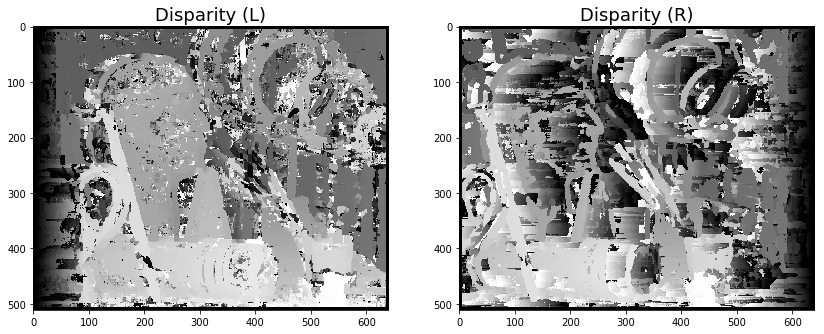

In [20]:
# Calculate diparity
Dln2ncorr, Drn2ncorr = disparity_ncorr(img2ln, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dln2ncorr, clim=(0,1));
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drn2ncorr, clim=(0,1));

Adding noise only to the left image has adverse effects on the generated disparity. Normalized correlation is not able to compensate for it.

#### ii. Different Contrasts

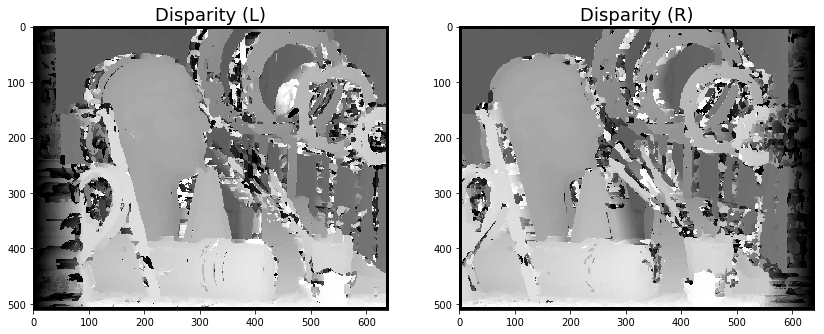

In [21]:
# Calculate diparity
Dlc2ncorr, Drc2ncorr = disparity_ncorr(img2lc, img2r, window_size=11, max_offset=100)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Disparity (L)')
ax[0].imshow(Dlc2ncorr, clim=(0,1));
ax[1].set_title('Disparity (R)')
ax[1].imshow(Drc2ncorr, clim=(0,1));

Since the pixel values are normalized before calculating the correlation, the difference in contrast has almost no effect on the output disparity images.

---
## 5. Stereo (Second Image)

In [22]:
# Load images
img3l = cv2.imread('Data/proj2-pair2-L.png', 0)
img3l = img3l.astype(np.float32) / 255
img3r = cv2.imread('Data/proj2-pair2-R.png', 0)
img3r = img3r.astype(np.float32) / 255

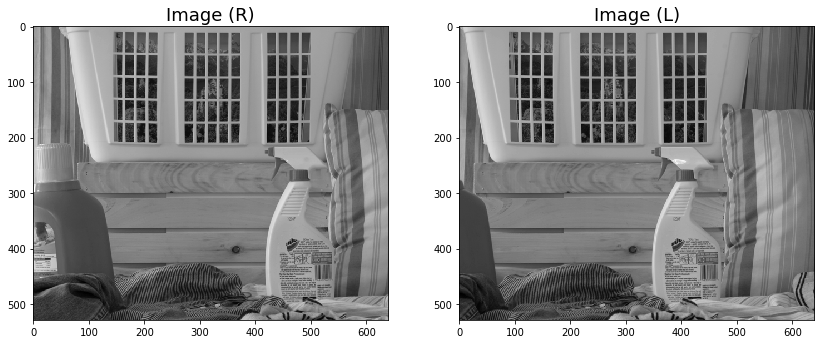

In [23]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image (R)')
ax[0].imshow(img3l)
ax[1].set_title('Image (L)')
ax[1].imshow(img3r);

In [24]:
# Load ground truth
img3lgt = cv2.imread('Data/proj2-pair2-Disp-L.png', 0)
img3lgt = img3lgt.astype(np.float32) / 255
img3rgt = cv2.imread('Data/proj2-pair2-Disp-R.png', 0)
img3rgt = img3rgt.astype(np.float32) / 255

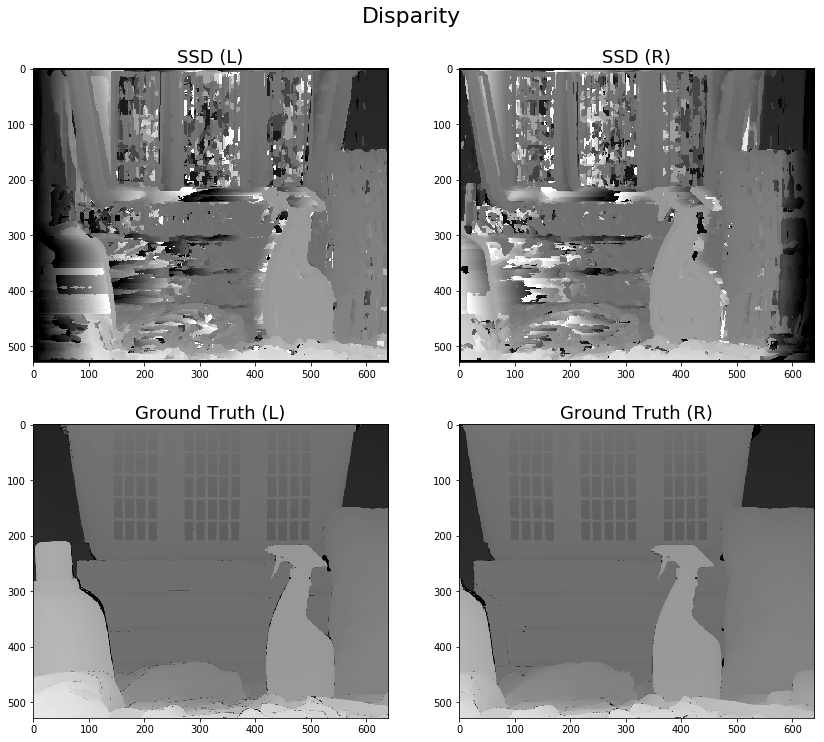

In [25]:
# SSD Disparity
Dl3, Dr3 = disparity_ssd(img3l, img3r, window_size=9, max_offset=120)
# Plot comparison
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('SSD (L)')
ax[0, 0].imshow(Dl3, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img3lgt, clim=(0,1));
ax[0, 1].set_title('SSD (R)')
ax[0, 1].imshow(Dr3, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img3rgt, clim=(0,1));

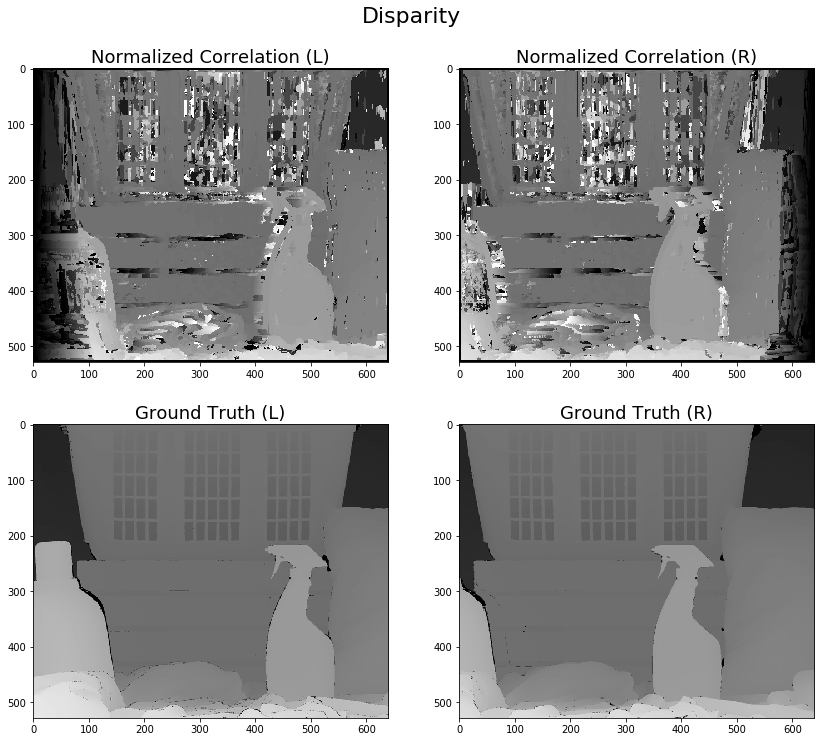

In [26]:
# Normalized Correlation diparity
Dl3ncorr, Dr3ncorr = disparity_ncorr(img3l, img3r, window_size=9, max_offset=120)
# Plot comparison
fig, ax = plt.subplots(2, 2, figsize=(14.0, 12.0))
fig.suptitle('Disparity', y=0.95)
ax[0, 0].set_title('Normalized Correlation (L)')
ax[0, 0].imshow(Dl3ncorr, clim=(0,1));
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img3lgt, clim=(0,1));
ax[0, 1].set_title('Normalized Correlation (R)')
ax[0, 1].imshow(Dr3ncorr, clim=(0,1));
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img3rgt, clim=(0,1));

Here, too, Normalized correlation performs better than SSD.